[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ianjure/mean-reversion-trading/blob/main/Mean_Reversion_Notebook.ipynb)

**Author:** Ian Jure Macalisang

**Email:** ianjuremacalisang2@gmail.com

**Link:** https://github.com/ianjure/mean-reversion-trading

**Website:** https://tradestrats.streamlit.app/meanreversion

# **I. Collecting the Data**

In [ ]:
# Installing Pandas TA
!pip install pandas_ta

In [75]:
# Importing libraries
import pandas as pd
import pandas_ta as ta
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import math

In [76]:
ticker = 'AAPL'
stock = yf.Ticker(ticker)
stock = stock.history(period='max')

# **II. Preprocessing the Data**

The Relative Strength Index (RSI) is a highly effective indicator for analyzing mean reversions. To enhance its robustness, we will combine it with the Simple Moving Average (SMA).

In this approach, we will use an RSI with a 10-period lookback and an SMA calculated over 200 periods.

In [77]:
def preprocess(stock):
    # Drop unnecessary columns
    del stock["Open"]
    del stock["High"]
    del stock["Low"]
    del stock["Volume"]
    del stock["Dividends"]
    del stock["Stock Splits"]

    # Rename 'Close' column to 'Price'
    stock.rename(columns={"Close": "Price"}, inplace=True)

    # Convert the index to a datetime object
    stock.index = stock.index.strftime('%Y-%m-%d')
    stock.index = pd.to_datetime(stock.index)

    # Calculate RSI 10 and SMA 200
    stock["RSI 10"] = ta.rsi(stock["Price"], length = 10)
    stock["SMA 200"] = ta.sma(stock["Price"], length = 200)

    return stock

In [78]:
stock = preprocess(stock)
stock.tail()

,Price,RSI 10,SMA 200
Date,,,
2024-08-28,226.490005,59.940326,193.235041
2024-08-29,229.789993,66.993643,193.455514
2024-08-30,229.000000,63.996478,193.680007
2024-09-03,222.770004,45.974100,193.860200
2024-09-04,220.850006,41.930598,194.027954


# **III. Simulating the Strategy**

Next, we will simulate the strategy by backtesting it using the stock's historical data.

**Entry conditions:** Enter (Buy) a position when the 10-period RSI drops below 30, and the price is above the 200-period SMA.

**Exit conditions:** Exit (Sell) the position when the 10-period RSI rises above 70, and the price falls below the 200-period SMA.

In [80]:
def run_simulation(stock, amount, verbose=False):

    """
    Simulates the execution of a Mean-Reversion trading strategy.

    Args:
        stock (pd.DataFrame): Historical stock data from Yahoo Finance, used for simulation.
        amount (int): The initial capital allocated for investment.
        verbose (bool): If True, detailed information about the simulation results is displayed.

    Returns:
        None: The function generates and displays a plot of the simulated trades and prints the expected returns
    """

    # Initialize trading variables
    in_position = False
    equity = amount

    # Preprocess the stock data
    stock = preprocess(stock)

    # Initialize starting date (2000-01-01)
    start_date = pd.to_datetime("2000-01-01")
    stock = stock.loc[start_date:]

    # Initialize the plot
    plt.figure(figsize = (20, 5))
    plt.plot(stock["Price"], color="black")
    plt.plot(stock["RSI 10"], color="orange")
    plt.plot(stock["SMA 200"], color="blue")
    plt.legend(["Price", "RSI 10", "SMA 200"], loc="upper left")

    # Create a dictionary for trade actions
    trade_actions = {
        "Buy": 0,
        "Sell": 0,
        "Total Actions": 0
    }

    # Loop through the stock data
    for i in range(0, len(stock)):

        # Entry (Buy): RSI 10 < 30 and Price > SMA 200
        if stock.iloc[i]["RSI 10"] < 30 and stock.iloc[i]["Price"] > stock.iloc[i]["SMA 200"] and in_position == False:

              # Calculate the number of shares to buy
              shares = math.floor(equity / stock.iloc[i]["Price"])

              # Buy the stock shares and set in position to true
              equity = equity - (shares * stock.iloc[i]["Price"])
              in_position = True

              # Action: Buy
              trade_actions["Buy"] += 1
              trade_actions["Total Actions"] += 1

              # Draw buy line
              plt.axvline(x=stock.index[i], color = 'g', lw=0.5)

        # Exit (Sell): RSI 10 > 370 and Price < SMA 200.
        elif stock.iloc[i]["RSI 10"] > 70 and stock.iloc[i]["Price"] < stock.iloc[i]["SMA 200"] and in_position == True:

              # Sell the stock shares and set in position to false
              equity = equity + (shares * stock.iloc[i]["Price"])
              in_position = False

              # Action: Sell
              trade_actions["Sell"] += 1
              trade_actions["Total Actions"] += 1

              # Draw sell line
              plt.axvline(x=stock.index[i], color = 'r', lw=0.5)

    # Close positions
    if in_position == True:
        equity = equity + (shares * stock.iloc[i]["Price"])
        in_position = False

        # Action: Sell
        trade_actions["Sell"] += 1
        trade_actions["Total Actions"] += 1

        # Draw close position line
        plt.axvline(x=stock.index[i], color = 'y', lw=0.5)

    # Show chart
    plt.show()

    # Calculate total earnings and return on investment
    total_earnings = round(equity - amount, 2)
    ROI = round(total_earnings / amount * 100, 2)

    # Print simulation results
    if verbose:
        print(f'\nBuy: {trade_actions["Buy"]}   Sell: {trade_actions["Sell"]}   Total Actions: {trade_actions["Total Actions"]}')
        print(f'Total Profit: {total_earnings}$   Total Amount: {round(equity, 2)}$   ROI: {ROI}%')
    else:
        print(f'\nTotal Profit: {total_earnings}$   Total Amount: {round(equity, 2)}$   ROI: {ROI}%')

    return None

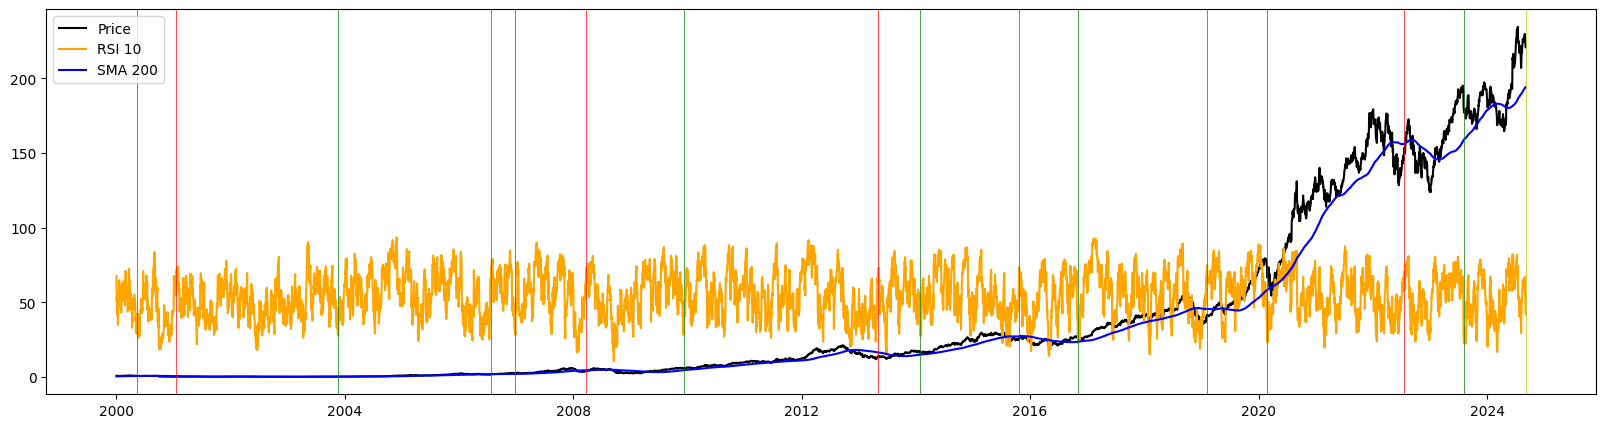


Buy: 8   Sell: 8   Total Actions: 16
Total Profit: 77919.62$   Total Amount: 78919.62$   ROI: 7791.96%


In [82]:
ticker = 'AAPL'
stock = yf.Ticker(ticker)
stock = stock.history(period='max')

run_simulation(stock=stock, amount=1000, verbose=True)